[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/11K8e51vPwsVyuAvxlpyTIb65HDkBCJdG?usp=sharing)

*Note: GitHub.com does not render everything when viewing these notbeook files, so click the "Open in Colab" button above to see everything as it's intended.*

# Still working on this Lesson!  
Not ready for prime time just yet, but getting there.

Check back later. 


# What is Deep Learning (DL)?

"Deep Learning" involves the Machine Learning (ML) approach to Artificial Intelligence (AI) in which multiple "layers" of "artificial neurons" are trained (via "gradient descent") to produce outputs that minimize a loss (or cost) function.

The term "Deep Learning" was coined by Geoffrey Hinton in the 200s as a way of "repranding the study of artificial neural networks (NNs) which ahd for sometime not been taken seriously outside a small community of researchers.  The "deep" part refers to the use of multiple successive "layers" of neuron connections in a "compositional" (e.g. $g(f(x))$) way.

"Machine Learning," a term coined by Arthur Samuels in the 1950s, differs from "classic" "symbolic" AI in that it (ML) involves the successive optimization of a system's behavior, rather than having (static) "expertise" programmed by humans.  Example: curve-fitting by successive adjustment of the curve parameters.  (Instead of a series of if-thens hard-coded by a person.)

TODO: add picture of MLP, mention universal approximation theorem,
define layers, show multiple layers

# Neural Networks Fit Curves

*Now that you've seen a bit of what artificial neural networks (ANN or just NN for short) **can** do, let's back up and look at what's going on under the hood.*

NNs fit "curves" to data. NNs are function-approximators. There is even something called the "universal approximation theorem" for which it's shown that any function can be approximated to any arbitrary accuracy by a single "layer" of arbitrarily many neurons. 

Let's look at how that plays out for a simple example. 

Again, since this course has an "AI Ethics" flavor, we're not going to just use any old function such as $f(x)=x^2$; instead we're goint to use some data (that I made up) involving *people.*

## Our Dataset: Your Risk of Death!

Let's pretend we've got some data on your risk of death before some age, based on...well, there are lots of factors we could imagine collecting:
  * your age
  * your driving habits
  * your diet 
  * how often you smoke
  * how often you engage in risky behavior
  * health outcomes for members of your family
  * whether you live in a "bad neighborhood"
  
...and that data on you is probably already available from [data brokers]().  

This particular problem has been handled by the insurance industry for hundreds of years. In fact it was [Francis Galton](https://en.wikipedia.org/wiki/Francis_Galton) "the father of statistics (and eugenics)" who petitioned the Institue of Actuaries to do more tracking of people in the UK in order to improve risk assessments! 

> Stop by Dr. Hawley's office sometime to try out a desktop "[Galton Board](https://galtonboard.com/)" toy: 

In [8]:
#@title Galton Board Video
from IPython.display import display, HTML
display(HTML('<video controls width="320" height="240"><source src="https://galtonboard.com/Content/Videos/galton-board-large_1_mobile_1.mp4" type="video/mp4"> </video>'))



The science of making these kinds of estimates is a branch of applied mathematics called Actuarial Science, and it involves a lot careful statistical modeling. Actuaries are typically highly trained and highly paid. 

But now we've got machine learning! And without hardly knowing any statistics, someone can come along and build a model and start "disrupting" the insurance industry!  (Note: for one accessible introduction to how insurance companies model risk, see [this white paper by Deloitte Consulting on "Predictive Modeling for Life Insurance"](https://www.soa.org/globalassets/assets/files/research/projects/research-pred-mod-life-batty.pdf)).

Even though ML models *can* be good at finding meaningful realtionships in data, if we just throw in "all the data we have" on someone, the model might not learn well, or it may waste lots of time and resources trying to fit to spurious things we're not interested.  So let's focus down to just two input features. 

For today's problem, let's say we have data on risk of death for certain people (presumably obtained by parsing some other data), as a function of their calori intake. I made up some numbers that sort of U-shaped (with some noise), to capture the idea that you don't want to each too much or two little. 

Also, to add another feature to the data, let's imagine that this company is offering a fitness-tracking app whereby we have some of your exercise frequency data! But not everyone has opted in to this exciting opportunity, so there are some blanks in our datatable. 

I'll show a graph of the data below, but first we need to import modules we'll need for todays code...

In [17]:
# install packages we'll use
!pip install plotly | grep -v already         # we'll use plotly for 3d graphs
! [ -e /content ] && pip install -Uqq fastai   # install upgrade fastai on colab
!pip install mrspuff | grep -v already

In [10]:
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from fastai.tabular.all import *
from fastai.learner import Learner
from fastai.optimizer import OptimWrapper
from fastai.callback.progress import *
from functools import partial 

Pretend that we've actually bought people's data with or without their consent, or invaded everyone's privacy or something, to obtain a set of data.   ...But really we're just going to generate a set of triplets of data that follow some wonky U-shapes, to show that doing things in moderation tends to lead to healthier outcomes. ;-) 

As follows...

## Our Data

First we're going to "get" some data. But actually I'm going to "make up" some data via a function that we can then *add noise* to, to better control and illustrate how the *curve-fitting* properties of neural networks manifest.  The following is a function that will serve as our "dataset-generator":

In [2]:
# I just made this up.  Generates a Pandas dataframe of some data.
# Don't worry about the specifics too much. You can skip down to look at the 
# 3D plot of the data, coming up after this.
def gen_df(n=50, noise_amp=0.15, seed=0, drop_frac=0.9):
    ''' 
    n = number of data points in each "direction"
    drop_frac = fraction of total points to randomly "drop"

    Output: a Pandas DataFrame object.  (Rows & columns)
    '''
    
    if seed is not None: np.random.seed(seed)
    uint = np.linspace(0,1,n)
    # some "wonky-u-shape" I made up
    d_vs_c = np.clip( 0.5+ 0.4*np.cos(uint**0.5 *2*np.pi) + noise_amp*(2*np.random.rand(n)-1), 0.05, 0.95) 
    d_vs_e = 0.5+ 0.3*np.cos(uint**1.6 *2*np.pi) # another wonky-u-shape
    data = []
    for i in range(len(d_vs_c)):   # nested loops in Python are slow, but we're only going to run this a couple times so :shrug:
        for j in range(len(d_vs_e)):
            data.append([ uint[i], uint[j], (d_vs_c[i]+0.3)*d_vs_e[j] + noise_amp*(2*np.random.rand()-1) ])
    data = np.clip( np.array(data), 0.05, 0.95 )  # make sure we don't go above or below zero
    # at this point, data is a numpy array

    if drop_frac > 0:    # randomly lose a fraction of the points, for "fun" ;-) 
        ndrop = int(data.shape[0] * drop_frac)  # how many to drop
        for i in range(ndrop):
            drop_row = np.random.randint(0, data.shape[0])  # pick a row
            data = np.delete(data, drop_row, 0)

    return pd.DataFrame(data, columns=["calories","exercise", "death_prob"])  # convert to pandas

df = gen_df(noise_amp=0, seed=0)  # start with a noise_amplitude of zero, we'll add noise later
print("We have", len(df),"data points")

We have 250 data points


And then let's plot what the data looks like in 3D:

In [3]:
# 3D scatter plots in matplotlib aren't interactive in Colab, so 
#  instead we'll use Plotly, which I like a lot: https://plotly.com/python/3d-scatter-plots/
def plot_df(df):
    fig = px.scatter_3d(data_frame=df, x="calories", y="exercise", z="death_prob", 
        color='death_prob', width=600, height=400)
    fig.update_traces(marker=dict(size=5))           # the dots are too big for my taste, by default
    fig.update_layout(margin=dict(l=20, r=20, t=20, b=20))  # default margins are way too big
    fig.show()

plot_df(df)

*^^ You can move this 3D plot around with your mouse (or finger if you're on a mobile device).* 

> DISCLAIMER: Any similarity between this data and actual health informatics and/or insurace data is purely coincidental!  (TODO: Replace this data with *real* data?)

.

Alternatively, if we were to ignore the fitness tracking info completely, that would be like projecting along the "exercise" axis and just looking at `calories`, which would look like this.

Text(0, 0.5, 'your risk of death!')

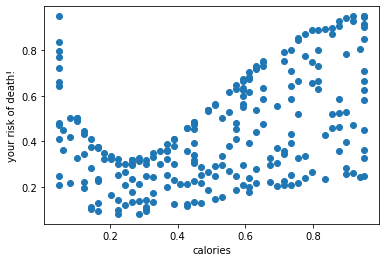

In [4]:
plt.plot(df['calories'], df['death_prob'], 'o')
plt.xlabel('calories')
plt.ylabel('your risk of death!')

"Training a model" on this data will mean that, given a value of "calories" (and maybe "exercise" too), we will get a number for your risk of death.  And that can be sent downstream to a different algorithm that decides how much to charge you for insurance. ;-) 

You don't "need" a neural network to fit a curve to this data!  But doing so will illustrate many of the core concepts we'll use as we progress in the course. 

To train a model on this simple dataset, we're going to use "raw" PyTorch with a little fastai thrown in.* 

>\**following [this post by Zach Mueller](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html) who showed how to "minimally" integrate fastai.* 

## Define Datasets & DataLoaders

What follows is a bunch of "Pandas" dataframe work, which we then use to set up *datasets* & *dataloaders*.


Also, let's decide if we're going to include `exercise` or not:

In [5]:
with_exercise = True  # are we going to include the exercise info or not?

# What follows just sets up which parts of df we're going to use 

df2 = df.copy() # make a copy of df for what happens below, just so we don't have to reload it after we 'break' it
input_cols = [0,1]

if not with_exercise:
    df2 = df2[['calories','death_prob']]
    input_cols = [0]

In [12]:
# Aside: we COULD use fastai TabularDataLoaders, as in...
#     dls = TabularDataLoaders.from_df(df, cont_names=['calories'], #, 'exercise'], 
#           y_names='death_prob',  valid_idx=list(range(40,50)), bs=10)
# But Nahhhh. Let's define our own using raw PyTorch


# Define a PyTorch dataset
class myDataset(Dataset):
    # got this from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    def __init__(self, df, input_cols=[0,1]):
        self.df = df
        self.ic = input_cols

    def __len__(self):   # required: method to return how many items are in the Dataset
        return len(self.df)

    def __getitem__(self, idx): # serve up a new x,y pair
        return Tensor(self.df.iloc[idx, self.ic].to_numpy() ), Tensor([self.df.iloc[idx,-1]])


batch_size = 5      # size of each mini-batch when we train
assert len(df) % batch_size == 0,"Batch size needs to divide evenly into length of dataset"  # sanity check



def df_to_dls(df): # produce fastai dataloaders from the pandas dataframe
    
    shuf_df = df2.sample(frac=1)   # "shuffled df": shuffle the order of rows
    n = len(shuf_df)

    # Manually split into train & val subsets
    split_ind = int(n*0.8)  # 80-20 split
    # split_ind = n-batch_size  # other option: all but one batch are training data

    train_df, val_df = shuf_df.iloc[0:split_ind], shuf_df.iloc[split_ind:]  # these are still pandas dataframes
    assert len(train_df) % batch_size == 0, f'{len(train_df)} mod {batch_size} = {len(train_df) % batch_size} != 0'   # otherwise you're gonna have a bad time
    assert len(val_df) % batch_size == 0, f'{len(val_df)} mod {batch_size} = {len(train_df) % batch_size} != 0'    # same

    train_ds, val_ds = myDataset(train_df, input_cols=input_cols), myDataset(val_df,input_cols=input_cols)
    train_dl, val_dl = DataLoader(train_ds, bs=batch_size), DataLoader(val_ds, bs=batch_size)

    dls = DataLoaders(train_dl,val_dl)  # fastai generic DataLoaders class
    return dls 

dls = df_to_dls(df)

Now let's define a neural network in raw PyTorch.  To do this we use the `nn.Module` class.  We can name the class of our network anything we want; let's call it `Net`.   We'll make it a single-hidden-layer neural network.

TODO: add a picture?

In [60]:
class Net(nn.Module): 
    # every PyTorch model class needs an __init__() and a forward()
    def __init__(self, 
        hidden_dim, # how many neurons in the hidden layer 
        in_dim=2,   # dimenisions of input 
        out_dim=1): # dimensions of output
        super().__init__()    # you always need this super() call for class inheritance
        # below is where we define our layers, thereby "allocating memory" in a sense
        self.layer_in = nn.Linear(in_dim, hidden_dim)   # Linear is just a matrix
        self.layer_out = nn.Linear(hidden_dim, out_dim)

    # forward() is where the actual computation is performed, x is the input
    def forward(self, x):           # for our raw, non-fastai-Tabular version
        x = self.layer_in(x)        # first set of weights
        x = F.relu(x)               # ReLU is nonlinear activation: max(0, x)
        return self.layer_out(x)    
         
# That was really a single-layer network: inputs, hidden, output

hidden_dim=15  # how many neurons in the hidden layer

torch.manual_seed(0)  # for reproducability 
net = Net(hidden_dim=hidden_dim, in_dim=df2.shape[1]-1)

# Let's integrate with "WandB" too!
TODO: Despite following explicit instructions, cannot get this to work! :-( 

*The following is totally optional but we'll use it now just to show off some of the tools that are available*

There's a great ML helper platform company called [Weights and Biases](https://wandb.ai/site) or "WandB".  It can keep track of all kinds of things about your training runs, and [it integrates with FastAI](https://docs.wandb.ai/guides/integrations/fastai) among other things.

> (Note: Link to [Full WandB-FastAI Walkthrough](https://wandb.ai/borisd13/demo_config/reports/Visualize-Track-Compare-Fastai-Models--Vmlldzo4MzAyNA), that I based this on, except things have CHANGED there since they wrote that!)

So, first go to WandB and create yourself a free account before going on. You can either create via username & password, or via an integration such as GitHub or...whatever else. (I use my GitHub account)

 Then come back...

In [8]:
# Don't need to (re-)run this every time. Just once per Colab session.
!pip install wandb | grep -v already
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


And then after the follow two lines of code, you'll get this giant white screen but just ignore if for now and keep going on...

In [ ]:
import wandb
from fastai.callback.wandb import *

## Train the model

In [67]:
opt_func = partial(OptimWrapper, opt=optim.Adam)  # Optimizer method

# note that we'll use the WandB callback for fastai:
wandb.init(project='4_nnsfitcurves')  # seems we gotta do this before every setup
learn = Learner(dls, net, loss_func=nn.MSELoss(), opt_func=opt_func, wd=0, cbs=WandbCallback())

Suggested learning rate =  0.005248074419796467


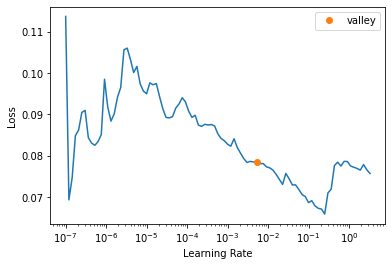

In [68]:
# fastai features a "Learning Rate Finder" that will suggest what learning rate to use
lr = learn.lr_find().valley
print("Suggested learning rate = ",lr)

Now we'll fit the model to the data points.  Watch both the training loss and the validation loss decrease as we train:

In [69]:
epochs = 50
learn.fit(epochs, lr=lr)
wandb.finish()  # they say finish is "optional" but...??

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'myDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,0.037359,0.021339,00:00
1,0.029267,0.017453,00:00
2,0.023791,0.016083,00:00
3,0.020096,0.015468,00:00
4,0.017274,0.014269,00:00
5,0.015064,0.013137,00:00
6,0.013245,0.012339,00:00
7,0.011734,0.011376,00:00
8,0.010442,0.010513,00:00
9,0.009346,0.009590,00:00


epoch,50
train_loss,0.00297
raw_loss,0.00364
lr_0,0.00525
mom_0,0.9
sqr_mom_0,0.999
eps_0,0.0
wd_0,0
amsgrad_0,False
lr_1,0.00525
mom_1,0.9


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▄▃█▅▃▃▃▂▂▂▃▃▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▁▁▂
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
amsgrad_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


...and if the `valid_loss` was still decreasing by the time that stopped, we may want to re-run the training but with more epochs.

OK! NOW go to your WandB page in another brower tab and check out all the data it generated!  In particular, see if you can find the graph for "valid_loss" as a function of time.  (Might have to press the down-arrrow in the bottom right in the WandB page)

And use this model to predict the death-probability for a wide range of possibile input values, and then plot the results:

In [70]:
def predict(model, c, e=-0.5):  # one prediction from the model
    # e=-0.5 means, if we weren't given a value for exercise, just assume it's -0.5
    if df2.shape[1] > 2:  # for two different cases of whether we included exercise or not
        return model.forward(Tensor([[c,e]])).item()
    else:
        return model.forward(Tensor([[c]])).item()


def predict_surface(model, show_points=True):
    # do a whole bunch of predictions across an entire surface
    outs = []
    ins_c = np.arange(0,1,0.05)  # calorie range
    ins_e = np.arange(df['exercise'].min(),1,0.05)  # exercise range
    for e in ins_e:
        outs_c = []
        for c in ins_c:
            outs_c.append(predict(model, c, e))
        outs.append(outs_c)

    # draw the surface
    if show_points: 
        fig = go.Figure(data=[
            go.Surface(x=ins_c, y=ins_e, z=np.array(outs), opacity=0.65, colorscale='Viridis'),    # fit
            go.Scatter3d(x=df['calories'], y=df['exercise'], z=df['death_prob'], mode='markers',  # points
            marker=dict( size=5, color=df['death_prob'],  opacity=0.8) ) ])
    else:
        fig = go.Figure(data=[go.Surface(x=ins_c, y=ins_e, z=np.array(outs), opacity=0.65, colorscale='Viridis')])
    fig.update_layout(scene = dict(xaxis_title='calories', yaxis_title="exercise", zaxis_title="risk of death!" ),
        autosize=False, width=600, height=500, margin=dict(l=20, r=20, b=25, t=20))
    fig.show()

predict_surface(learn.model, show_points=True)

Now it's still really blocky.  What if we went back and added lots more neurons?   


## Exercise 1: Add more neurons to the hidden layer
Try this yourself: Scroll up to the line `hidden_dim=15`, and change the 20 to something larger, such as 100, and re-train.

In [65]:
# Or you can run this code here and THEN scroll up and re-train 

hidden_dim=100  # how many neurons in the hidden layer

torch.manual_seed(0)  # for reproducability 
net = Net(hidden_dim=hidden_dim, in_dim=df2.shape[1]-1)

# now scroll up and re-train ("Train the Model"), and re-plot the surface...then come back here and keep reading

...then re-run all the code from that point up to the surface plot we just made.  Notice any difference?  
* Is the surface more curvier than before?
* Are the loss values lower than before?

## Exercise 2: Add more layers
We can define a neural network in terms of a list of layers that feed into one another.  We'll just use a list `hidden_dims = [..,..,..]` to specify the number of neurons in each layer, and we'll put ReLUs on all of them except the output:

In [57]:
class Net2(nn.Module): 
    # every PyTorch model class needs an __init__() and a forward()
    def __init__(self, 
        hidden_dims=[], # list of how many neurons in each hidden layers[] 
        in_dim=2,   # dimenisions of input 
        out_dim=1): # dimensions of output
        super().__init__()    # you always need this super() call for class inheritance

        self.activation = F.relu    # we'll use ReLU activations, but feel free to try others, see "Non-linear activation functions", https://pytorch.org/docs/stable/nn.functional.html

        # below is where we define our layers, thereby "allocating memory" in a sense
        self.layers = nn.ModuleList()                       # special kind of list [] for pytorch layers
        self.layers.append ( nn.Linear(in_dim, hidden_dims[0]) )  # first hidden layer
        for i in range(len(hidden_dims)-1):
            self.layers.append( nn.Linear(hidden_dims[i], hidden_dims[i+1])  )
        self.layers.append( nn.Linear(hidden_dims[-1], out_dim) )
 
    # forward() is where the actual computation is performed, x is the input
    def forward(self, x):           # for our raw, non-fastai-Tabular version
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1: x = self.activation(x)    # do activations for all layers except the output           
        return x   
         
# That was really a single-layer network: inputs, hidden, output

hidden_dims=[40,40,40]  # how many neurons in the hidden layer

torch.manual_seed(0)  # for reproducability 
net2 = Net2(hidden_dims=hidden_dims, in_dim=df2.shape[1]-1)

Suggested LR =  0.009120108559727669


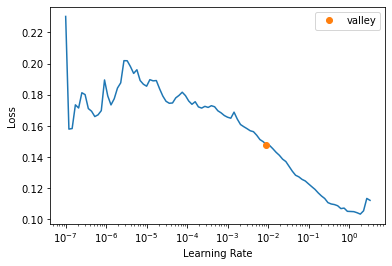

In [58]:
learn = Learner(dls, net2, loss_func=nn.MSELoss(), opt_func=opt_func, cbs=WandbCallback())
lr = learn.lr_find().valley
print("Suggested LR = ",lr)

In [59]:
wandb.init(project="4_nnsfitcurves")
learn.fit(epochs, lr=lr)
wandb.finish()

epoch,250
train_loss,0.00297
raw_loss,0.00364
lr_0,0.00525
mom_0,0.9
sqr_mom_0,0.999
eps_0,0.0
wd_0,0
amsgrad_0,False
lr_1,0.00525
mom_1,0.9


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,▄▃█▅▃▃▃▂▂▂▃▃▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▁▁▂
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
amsgrad_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'myDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,0.052814,0.034421,00:00
1,0.038425,0.023857,00:00
2,0.031064,0.024279,00:00
3,0.025596,0.018431,00:00
4,0.019548,0.012058,00:00
5,0.015021,0.007363,00:00
6,0.011083,0.004744,00:00
7,0.008573,0.004200,00:00
8,0.007074,0.003000,00:00
9,0.005674,0.002921,00:00


In [31]:
predict_surface(learn.model, show_points=True)

## Exercise 4: Add noise to the data

Let's add a bit of noise to the data by regenerating the dataframe (from WAYY up at the top of this)

In [ ]:
df = gen_df(noise_amp = 0.15)
plot_df(df)  # take a look

Now go back up and re-assign your dataloaders (i.e., run `dls = df_to_dls(df)`, see "Define Datasets & DataLoaders" above), and retrain the model.  What do you notice?

Spend a lot of time on this.  In particular, you should notice that it's possible to get the Training loss to go as low as you want, but that the Validation loss will "plateau" at a certain value and then eventually start increasing!  This is what's known as *overfitting*.  If you plot your surface, you may see that it has lots of extra "wiggles" as it tries to fit every data point (in the Training set).

## Exercise 5: Mess Around with (/Explore) Karpathy's Demo

We've been working with 2 input "features" of input and one output.  As a way of seeing the effects your neural network modifications a little faster, let's switch to 1 feature and one output using [Andrej Karpathy's "toy 1d regression" Demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/regression.html).  

By clicking in the diplay, you can add data points that the model will try to fit to.  You can also edit the (number and size of) layers and the activations between them.
Explore different layer layouts, try different activations (such as 'relu', 'sigmoid', 'tanh').

## Assignment!

This will be a separate notebook.  It will involve defining a PyTorch model Class called "NewModel" (i.e., instead of "Net" like we did above), with certain attributes.
